# Region of Interest (ROI) Extraction from ORIGA dataset images

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import os

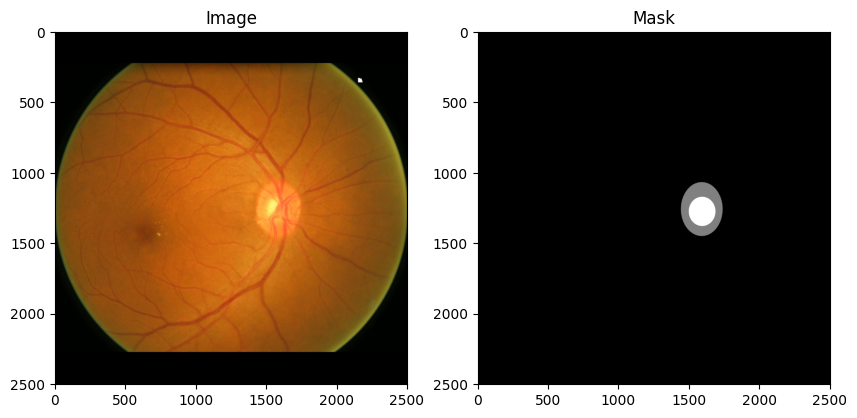

In [2]:
DATA_DIR = '../data/ORIGA/CenterNet/'
IMAGES_DIR = DATA_DIR + 'TestImages'
MASKS_DIR = DATA_DIR + 'TestMasks'

image_paths = sorted(os.path.join(IMAGES_DIR, f) for f in os.listdir(IMAGES_DIR))
mask_paths = sorted(os.path.join(MASKS_DIR, f) for f in os.listdir(MASKS_DIR))

img = cv.imread(image_paths[143])
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
mask = cv.imread(mask_paths[143], cv.IMREAD_GRAYSCALE)

_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[0].set_title('Image')
ax[1].imshow(mask, cmap='gray')
ax[1].set_title('Mask')
plt.show()

## Method 1: Intensity weighted centroid

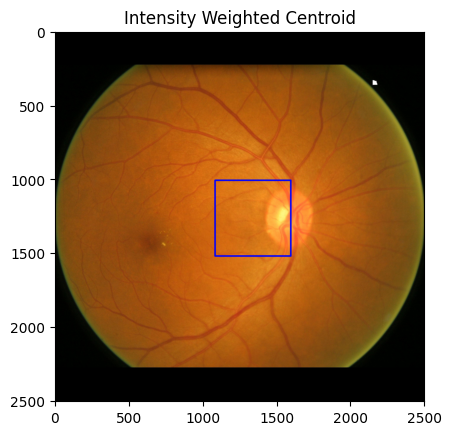

In [3]:
from ROI.intensity_weighted_centroid import IntensityWeightedCentroid

iwc = IntensityWeightedCentroid(
    512, 512, channel=-1, equalize=True, clahe=True, square=True,
    dampening='circular', k_size=65, quantile=0.9,
)
iwc.show(img)

In [ ]:
iwc.generate_dataset(
    src_images_dir=IMAGES_DIR,
    src_masks_dir=MASKS_DIR,
    dst_images_dir=DATA_DIR + '/Images_IntensityWeightedCentroid',
    dst_masks_dir=DATA_DIR + '/Masks_IntensityWeightedCentroid',
)

## Method 2: Brightest spot algorithm

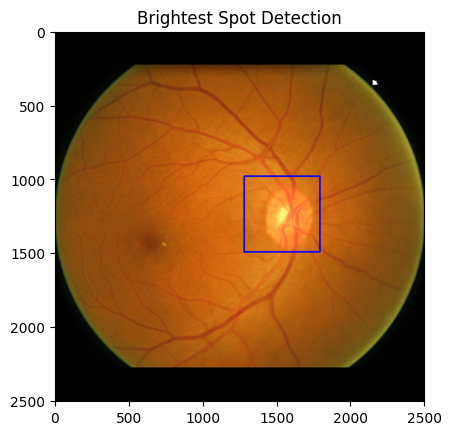

In [4]:
from ROI.brightest_spot import BrightestSpot

bs = BrightestSpot(512, 512, channel=-1, dampening='circular', k_size=65)
bs.show(img)

In [ ]:
bs.generate_dataset(
    src_images_dir=IMAGES_DIR,
    src_masks_dir=MASKS_DIR,
    dst_images_dir=DATA_DIR + '/Images_BrightestSpot',
    dst_masks_dir=DATA_DIR + '/Masks_BrightestSpot',
)

## Method 3: Thresholding channel

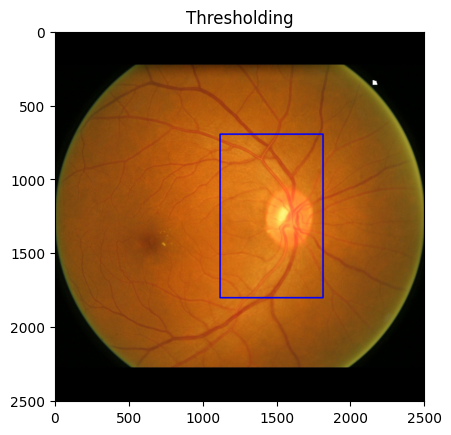

In [5]:
from ROI.thresholding import Thresholding

th = Thresholding(margin=50, channel=2, crop_size=250, k_size=35)
th.show(img)

In [ ]:
th.generate_dataset(
    src_images_dir=IMAGES_DIR,
    src_masks_dir=MASKS_DIR,
    dst_images_dir=DATA_DIR + '/Images_Threshold',
    dst_masks_dir=DATA_DIR + '/Masks_Threshold',
)

## Method 4: Template Matching

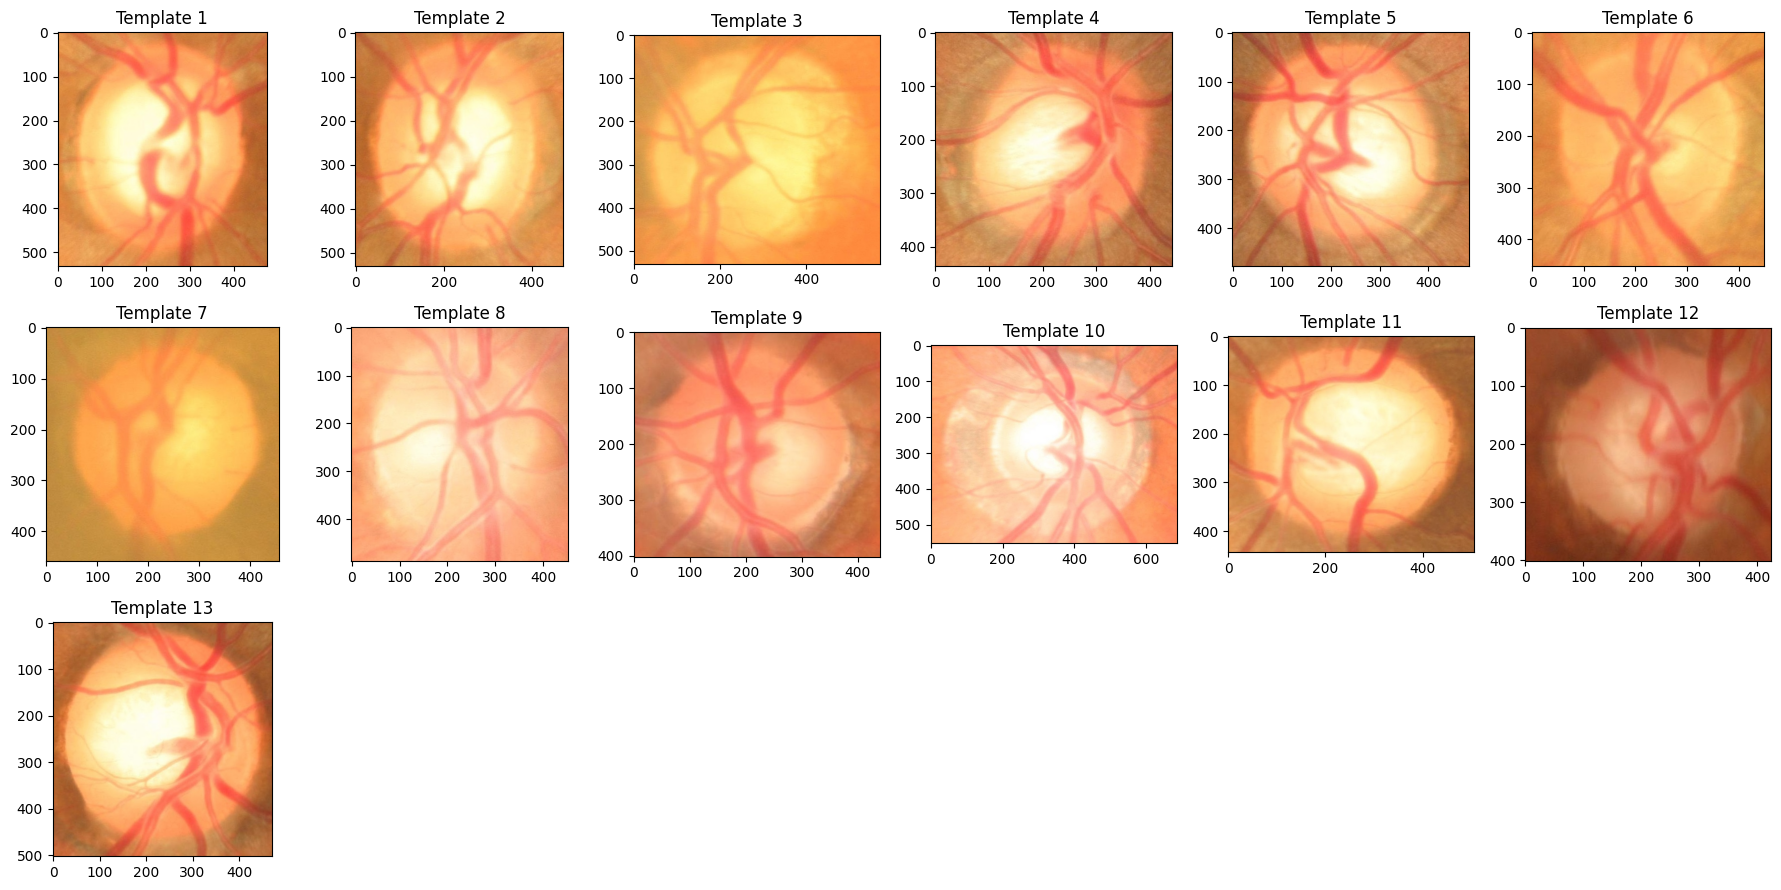

In [3]:
from ROI.template_matching import TemplateMatching, get_templates

templates = get_templates('../data/ORIGA/Templates', show=True)

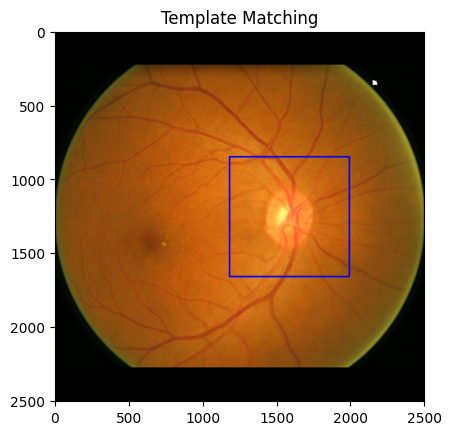

In [7]:
tm = TemplateMatching(
    templates,
    margin_x=60, margin_y=60,
    shape=(512, 512),
    scale=0.1,
    min_confidence=0.6,
    reduce='join',
)
tm.show(img)

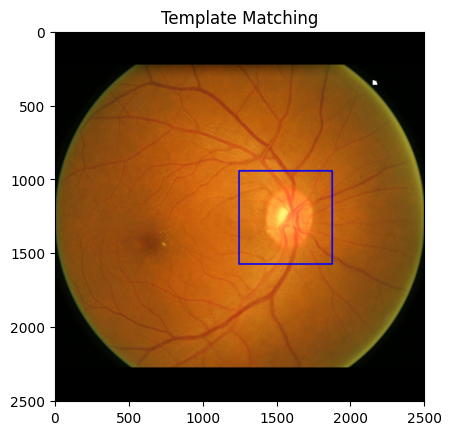

In [8]:
tm = TemplateMatching(
    templates,
    margin_x=60, margin_y=60,
    shape=(512, 512),
    scale=0.1,
    min_confidence=0.6,
    reduce='mean',
)
tm.show(img)

In [ ]:
tm.generate_dataset(
    src_images_dir=IMAGES_DIR,
    src_masks_dir=MASKS_DIR,
    dst_images_dir=DATA_DIR + '/Images_TemplateMatching',
    dst_masks_dir=DATA_DIR + '/Masks_TemplateMatching',
)